**Adding libraries and dependencies**

In [24]:
import numpy as np
import tensorflow as tf

from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel
from mlagents_envs.base_env import ActionTuple

import tf_agents
from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.networks import q_network
from tf_agents.agents.dqn import dqn_agent
from tf_agents.utils import common
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import array_spec
from tf_agents.policies import policy_saver
from tf_agents.agents.ppo import ppo_agent
from tf_agents.networks import actor_distribution_network, value_network
from tf_agents.drivers.dynamic_episode_driver import DynamicEpisodeDriver

import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

Checking GPU detection

In [4]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Establishing connection with Unity environment**

In [166]:
env.close()

UnityEnvironmentException: No Unity environment is loaded.

In [5]:
engine_config_channel = EngineConfigurationChannel()

env = UnityEnvironment(
    file_name=None,
    worker_id=0,
    base_port=5004,
    side_channels=[engine_config_channel]
)

In [6]:
env.reset()
behavior_names = list(env.behavior_specs)
behavior_name = behavior_names[0]
behavior_spec = env.behavior_specs[behavior_name]

print(f"Behavior: {behavior_name}")
print(f"Action branches: {behavior_spec.action_spec.discrete_branches}")
print(f"Observation shapes: {[obs.shape for obs in behavior_spec.observation_specs]}")

decision_steps, terminal_steps = env.get_steps(behavior_name)
print(f"Active agents: {len(decision_steps)}")

Behavior: RobotBehaviour?team=0
Action branches: (5,)
Observation shapes: [(45,), (12,)]
Active agents: 1


### Action Space
- **5 discrete actions** corresponding to possible movements:
  - `0`: Do nothing
  - `1`: Go right  
  - `2`: Go left
  - `3`: Go forward
  - `4`: Go backwards

### Observation Space

#### Ray Perception (45 dimensions)
- **45 values** from ML-Agents Ray Perception Sensor 3D component
- Detects tags and distances in the environment. It detects the tags: Floor, GoodSphere, Badsphere. The Sensor contains 9 rays, each contains these following 5 observations:
  - GoodSphere: `0` not detected, `1` detected
  - BadSphere: `0` not detected, `1` detected
  - Floor: `0` not detected, `1` detected
  - No-hit flag: `1` didn't detect anything, `1` detected something
  - Distance: varies from `0`(close) to `1`(far)

#### Agent State (12 dimensions)
- **12 normalized values** divided as follows:
  - Position: `x`, `z` coordinates
  - Velocity: `x`, `z` velocity components  
  - Rotation: 4 one-hot encoded values `forward` `backwards` `left` `right`
  - Distances to floor bounds: `top`, `bottom`, `right`, `left` 

**Total observation size:** 57

---

In [7]:
action_size = 5
state_size = 57

Preparing a get_state function for model training and inference, that is responsible for getting the agent's state at the current step and returning information which will later be used by the model :
- state (55,) : agent's state at the current step
- reward (float) : reward of the current step
- done (boolean) : whether the episode is terminated at the current step

In [8]:
def get_state():
    decision_steps, terminal_steps = env.get_steps(behavior_name)
    
    if len(decision_steps) > 0:
        obs1 = decision_steps.obs[0][0] #Ray perception sensor observations
        obs2 = decision_steps.obs[1][0] #Agent state observations
        state = np.concatenate([obs1, obs2]) #Combine observations for correct DQN input format
        return state, decision_steps.reward[0], False
    
    elif len(terminal_steps) > 0:
        # Episode ended
        obs1 = terminal_steps.obs[0][0]
        obs2 = terminal_steps.obs[1][0] 
        state = np.concatenate([obs1, obs2])
        return state, terminal_steps.reward[0], True
    
    return None, 0, False


**Making a random Neural Network**

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(state_size,)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(action_size, activation='linear')
])

2025-08-16 23:20:15.022399: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-16 23:20:15.022522: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-16 23:20:15.022545: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-16 23:20:15.163690: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-16 23:20:15.163759: I external/local_xla/xla/stream_executor

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               14336     
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 5)                 645       
                                                                 
Total params: 310789 (1.19 MB)
Trainable params: 310789 (1.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
l1_weights = model.get_weights()[0]
l1_weights[:,0] #weights of the first neuron of the first layer

array([ 0.0681653 , -0.02005782, -0.05309546, -0.03974345, -0.0163302 ,
       -0.07047646,  0.05911955, -0.11428588,  0.12264444,  0.08044188,
       -0.13879119, -0.04777802,  0.05082954, -0.13628846, -0.01311588,
       -0.1346899 , -0.13345994,  0.0777429 , -0.09758136, -0.0744898 ,
        0.05861302, -0.13591236, -0.11990199,  0.09239155,  0.00921832,
        0.10093576, -0.08389317, -0.12106803, -0.12084341,  0.01047648,
       -0.00533745,  0.0417757 , -0.05224332, -0.12261838,  0.09011672,
       -0.12578855, -0.03288994, -0.0472386 ,  0.02029659, -0.04158714,
       -0.06799771, -0.08428632, -0.1051219 , -0.0520586 , -0.10774223,
        0.11603223,  0.0664769 ,  0.00097778, -0.08391118, -0.10806252,
        0.12235253, -0.04933532, -0.08178091,  0.03291407, -0.07054544],
      dtype=float32)

Running the model with the initial random weights

In [11]:
for step in range(100): #Run for 100 steps
    state, reward, done = get_state()
    
    if state is not None:
        if done:
            env.reset()
        q_values = model.predict(np.expand_dims(state, axis=0), verbose=0)
        action = np.argmax(q_values[0])  # Choose best action
        
        if step % 10 == 0: 
            print(f"Step {step}: Action {action}, Reward {reward:.2f}")
        
        # Send action to Unity
        action_tuple = ActionTuple(discrete=np.array([[action]]))
        env.set_actions(behavior_name, action_tuple)
        env.step()
    else:
        env.close()
    

2025-08-16 23:20:22.884867: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Step 0: Action 3, Reward 0.00
Step 10: Action 1, Reward 0.00
Step 20: Action 2, Reward 0.00
Step 30: Action 2, Reward 0.00
Step 40: Action 4, Reward 0.00
Step 50: Action 1, Reward 0.00
Step 60: Action 0, Reward -25.00
Step 70: Action 0, Reward -25.00
Step 80: Action 0, Reward -25.00
Step 90: Action 0, Reward -25.00


**Creating environment wrapper for TF agents**

In [10]:
class EnvironmentWrapper(py_environment.PyEnvironment):
    def __init__(self, unity_env, behavior_name, get_state_func):
        super().__init__()
        self.unity_env = unity_env
        self.behavior_name = behavior_name
        self.get_state_func = get_state_func

        self._action_spec = array_spec.BoundedArraySpec(
            shape=(),
            dtype=np.int32,
            minimum=0,
            maximum=4,
            name='action'
        )
        self._observation_spec = array_spec.ArraySpec(
            shape=(state_size,),
            dtype=np.float32,
            name='observation'
        )

        self._state = np.zeros(state_size, dtype=np.float32)
        self._episode_ended = False

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self.unity_env.reset()
        self._episode_ended = False
        state, _, _ = self.get_state_func()
        if state is not None:
            self._state = state.astype(np.float32)
        return tf_agents.trajectories.time_step.restart(self._state)

    def _step(self, action):
        if self._episode_ended:
            return self.reset()
        
        # Send action to Unity
        action_tuple = ActionTuple(discrete=np.array([[action]]))
        self.unity_env.set_actions(self.behavior_name, action_tuple)
        self.unity_env.step()
        
        # Get new state
        state, reward, done = self.get_state_func()

        if state is not None:
            self._state = state.astype(np.float32)
        
        if done:
            self._episode_ended = True
            return tf_agents.trajectories.time_step.termination(self._state, reward)
        else:
            return tf_agents.trajectories.time_step.transition(self._state, reward)

In [7]:
env_wrapper = EnvironmentWrapper(env, behavior_name, get_state)
tf_env = tf_py_environment.TFPyEnvironment(env_wrapper)

NameError: name 'get_state' is not defined

**Setting the architecture of the Q-neural-networks**

In [149]:
q_net = q_network.QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    fc_layer_params=(256, 512, 256, 128)
)

**Creating the agent (Deep-Q-Network)**

In [150]:
train_step_counter = tf.Variable(0)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

agent = dqn_agent.DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter,
    epsilon_greedy=0.1,
    target_update_period=100,
    gamma=0.99 
)

agent.initialize()

**Creating the replay buffer**

In [151]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=100000
)

**Creating policies**

In [152]:
eval_policy = agent.policy # greedy: for testing and inference
collect_policy = agent.collect_policy # Epsilon-greedy: for training and exploration
random_policy = random_tf_policy.RandomTFPolicy(  # Completely random: for initial data collection
    tf_env.time_step_spec(), 
    tf_env.action_spec()
)

**Data collection**

In [ ]:
def collect_data(policy, steps, env, replay_buffer):
    for i in range(steps):
        time_step = env.current_time_step()
        action_step = policy.action(time_step)
        next_time_step = env.step(action_step.action)
        traj = trajectory.from_transition(time_step, action_step, next_time_step)
        replay_buffer.add_batch(traj)
        if i % 100 == 0 and i > 0:
            print(f"Collected {i} steps")

### **Training the model**
 ##### **1<sup>st</sup> round of training**
During this round, the agent learns not to fall. We remove the items from the environment and we change the reward like this:
- Falling : -100
- Doing nothing : -50 (to encourage the agent to learn to move without falling)

Collecting initial data randomly

In [163]:
#clearing the replay buffer in case it has some experiments from previous collections
replay_buffer.clear()

In [ ]:
engine_config_channel.set_configuration_parameters(time_scale=5)
env.reset()
collect_data(random_policy, 1000, tf_env, replay_buffer)

Collected 100 steps
Collected 200 steps
Collected 300 steps
Collected 400 steps
Collected 500 steps
Collected 600 steps
Collected 700 steps
Collected 800 steps
Collected 900 steps


In [ ]:
num_iterations = 10000
collect_steps_per_iteration = 4
batch_size = 64
speed = 100
eval_interval = 200

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2
).prefetch(3)

iterator = iter(dataset)

In [ ]:
train_losses = []
episode_returns = []

engine_config_channel.set_configuration_parameters(time_scale=speed)
env.reset()

for iteration in range(num_iterations):
    #collect data for 4 steps
    collect_data(collect_policy, collect_steps_per_iteration, tf_env, replay_buffer)

    # Sample a random batch from the replay buffer and train the agent
    experience, _ = next(iterator)
    train_loss = agent.train(experience).loss
    
    training_step = agent.train_step_counter.numpy()

    # Log and evaluate each 200 training step
    if training_step % eval_interval == 0:
        print(f'Training step {training_step}: Loss = {train_loss:.4f} | Env step = {iteration * collect_steps_per_iteration}')
        train_losses.append(train_loss.numpy())
        
        episode_return = 0.0
        steps_in_episode = 0

        while not time_step.is_last() and steps_in_episode < 500:
            action_step = eval_policy.action(time_step)
            time_step = tf_env.step(action_step.action)
            episode_return += time_step.reward
            steps_in_episode += 1
            
        episode_returns.append(episode_return.numpy()[0])
        print(f'Evaluation episode Return: {episode_return.numpy()[0]:.2f}')

print("Training complete")

Training step 200: Loss = 0.7196 | Env step = 796
Evaluation episode Return: -100.00
Training step 400: Loss = 0.5428 | Env step = 1596
Evaluation episode Return: 0.00
Training step 600: Loss = 0.5635 | Env step = 2396
Evaluation episode Return: -100.00
Training step 800: Loss = 0.1308 | Env step = 3196
Evaluation episode Return: -100.00
Training step 1000: Loss = 0.0667 | Env step = 3996
Evaluation episode Return: -100.00
Training step 1200: Loss = 0.0141 | Env step = 4796
Evaluation episode Return: -100.00
Training step 1400: Loss = 0.4820 | Env step = 5596
Evaluation episode Return: -100.00
Training step 1600: Loss = 0.0545 | Env step = 6396
Evaluation episode Return: -100.00
Training step 1800: Loss = 0.0560 | Env step = 7196
Evaluation episode Return: -100.00
Training step 2000: Loss = 0.0557 | Env step = 7996
Evaluation episode Return: -100.00
Training step 2200: Loss = 0.0395 | Env step = 8796
Evaluation episode Return: -100.00
Training step 2400: Loss = 0.0976 | Env step = 9596

Visualizing training information

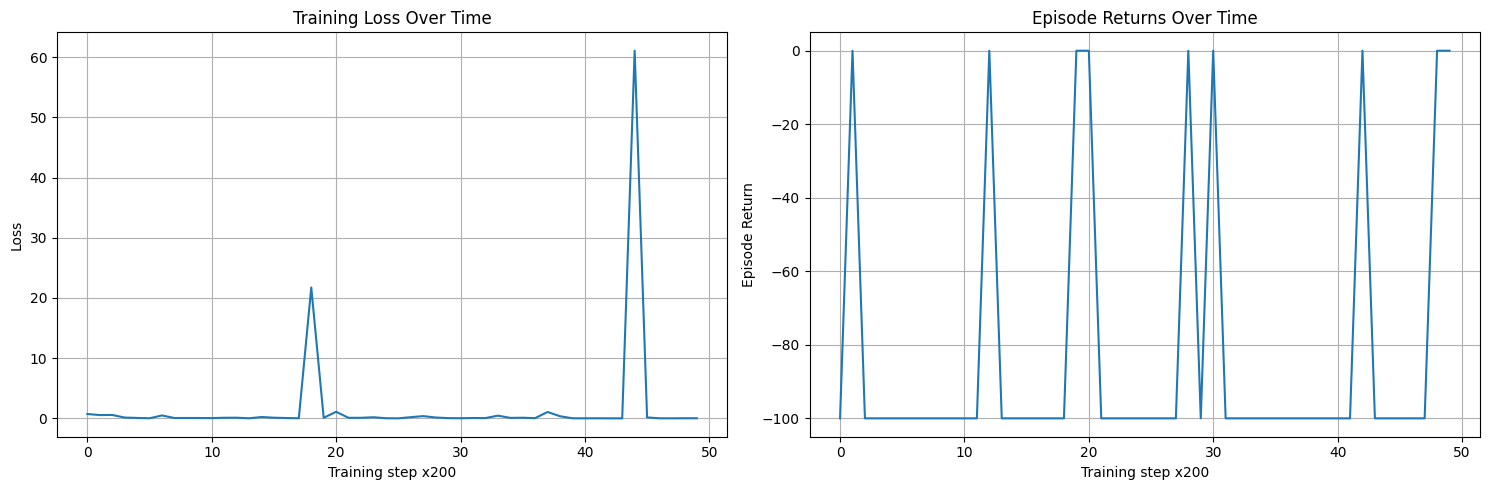

In [167]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses)
ax1.set_title('Training Loss Over Time')
ax1.set_xlabel('Training step x200')
ax1.set_ylabel('Loss')
ax1.grid(True)

ax2.plot(episode_returns)
ax2.set_title('Episode Returns Over Time')
ax2.set_xlabel('Training step x200')
ax2.set_ylabel('Episode Return')
ax2.grid(True)

plt.tight_layout()
plt.show()

Running evaluation episodes

In [ ]:
total_returns = []
total_steps = []

engine_config_channel.set_configuration_parameters(time_scale=2)
for episode in range(10):
    time_step = tf_env.reset()
    episode_return = 0.0
    steps_in_episode = 0

    while not time_step.is_last():
        action_step = eval_policy.action(time_step)
        time_step = tf_env.step(action_step.action)
        episode_return += time_step.reward
        steps_in_episode += 1
    
    total_returns.append(episode_return.numpy()[0])
    total_steps.append(steps_in_episode)
    print(f"Episode {episode+1}: Return = {episode_return.numpy()[0]:.2f}, Steps = {steps_in_episode}")

avg_return = np.mean(total_returns)
avg_steps = np.mean(total_steps)
std_return = np.std(total_returns)

print(f"Average Return: {avg_return:.2f}")
print(f"Average Episode Length: {avg_steps:.1f} steps")
print(f"Best Episode: {max(total_returns):.2f}")
print(f"Worst Episode: {min(total_returns):.2f}")

Episode 1: Return = 0.00, Steps = 400
Episode 2: Return = 0.00, Steps = 400
Episode 3: Return = 0.00, Steps = 400
Episode 4: Return = 0.00, Steps = 400
Episode 5: Return = 0.00, Steps = 400
Episode 6: Return = 0.00, Steps = 400
Episode 7: Return = 0.00, Steps = 400
Episode 8: Return = 0.00, Steps = 400
Episode 9: Return = 0.00, Steps = 400
Episode 10: Return = 0.00, Steps = 400
Average Return: 0.00
Average Episode Length: 400.0 steps
Best Episode: 0.00
Worst Episode: 0.00


Visualizing evaluation information

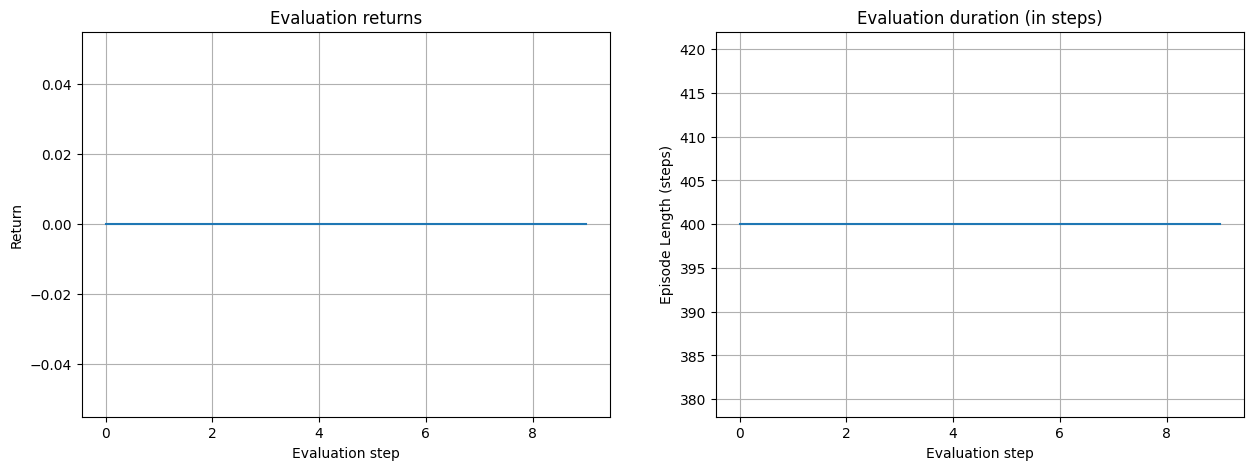

In [169]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(total_returns)
ax1.set_title('Evaluation returns')
ax1.set_xlabel('Evaluation step')
ax1.set_ylabel('Return')
ax1.grid(True)

ax2.plot(total_steps)
ax2.set_title('Evaluation duration (in steps)')
ax2.set_xlabel('Evaluation step')
ax2.set_ylabel('Episode Length (steps)')
ax2.grid(True)

In [176]:
env.close()

Saving the No-Fall policy and checkpoint

In [170]:
no_fall_policy_saver = policy_saver.PolicySaver(agent.policy)
no_fall_policy_saver.save('./saved_models/no_fall_agent')

# Save the entire agent state for continued training
checkpoint = tf.train.Checkpoint(
    q_net=agent._q_network,
    target_q_net=agent._target_q_network,
    optimizer=agent._optimizer,
    train_step=agent.train_step_counter
)
checkpoint.save('./checkpoints/no_fall_checkpoint')

INFO:tensorflow:Assets written to: ./saved_models/no_fall_agent/assets


/home/louay/miniforge3/envs/DQL_env/lib/python3.10/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: ./saved_models/no_fall_agent/assets


'./checkpoints/no_fall_checkpoint-1'

##### **2<sup>nd</sup> round of training**
During this round, the agent learns to collect good items (green spheres). We remove the red spheres from the environment and we change the rewards like this:
- Falling: -100
- Doing nothing: -5 (encouraging movement)
- Collecting green sphere: +50
- Getting closer to spheres: + (20 x (1 - distance to closest green sphere))

Changing the get_state implementation to add the reward for getting closer to green spheres

In [224]:
def get_state_2():
    decision_steps, terminal_steps = env.get_steps(behavior_name)
    
    if len(decision_steps) > 0:
        obs1 = decision_steps.obs[0][0]
        obs2 = decision_steps.obs[1][0]
        reward = decision_steps.reward[0]
        
        ray_data = obs1.reshape(9, 5)
        sphere_distances = ray_data[ray_data[:, 0] > 0, 4]

        if len(sphere_distances) > 0:
            closest_sphere_dist = np.min(sphere_distances)
            reward += 3 * (1 - closest_sphere_dist)

        state = np.concatenate([obs1, obs2])
        return state, reward, False
        
    elif len(terminal_steps) > 0:
        obs1 = terminal_steps.obs[0][0]
        obs2 = terminal_steps.obs[1][0]
        state = np.concatenate([obs1, obs2])
        return state, terminal_steps.reward[0], True
    
    return None, 0, False

Creating a new environment wrapper that supports the new get_state function

In [225]:
env_wrapper_2 = EnvironmentWrapper(env, behavior_name, get_state_2)
tf_env_2 = tf_py_environment.TFPyEnvironment(env_wrapper_2)

Creating second agent with slightly different hyperparameters (for fine-tuning)

In [226]:
q_net_2 = q_network.QNetwork(
    tf_env_2.observation_spec(),
    tf_env_2.action_spec(),
    fc_layer_params=(256, 512, 256, 128)
)

train_step_counter_2 = tf.Variable(0)
optimizer_2 = tf.keras.optimizers.Adam(learning_rate=0.01)

agent_2 = dqn_agent.DqnAgent(
    tf_env_2.time_step_spec(),
    tf_env_2.action_spec(),
    q_network=q_net_2,
    optimizer=optimizer_2,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter_2,
    epsilon_greedy=0.9,
    target_update_period=100,
    gamma=0.99
)

agent_2.initialize()

Restoring the No-Fall agent checkpoint

In [206]:
checkpoint_2 = tf.train.Checkpoint(
    q_net=agent_2._q_network,
    target_q_net=agent_2._target_q_network,
    optimizer=agent_2._optimizer,
    train_step=agent_2.train_step_counter
)

checkpoint_path = checkpoint_2.restore('./checkpoints/no_fall_checkpoint-1')

ValueError: Received incompatible tensor with shape (55, 256) when attempting to restore variable with shape (57, 256) and name QNetwork/EncodingNetwork/dense_215/kernel:0.

Creating replay buffer for second round of training

In [227]:
stage2_replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent_2.collect_data_spec,
    batch_size=tf_env_2.batch_size,
    max_length=100000
)

Setting up the new policies

In [228]:
eval_policy_2 = agent_2.policy
collect_policy_2 = agent_2.collect_policy
random_policy_2 = random_tf_policy.RandomTFPolicy(
    tf_env_2.time_step_spec(), 
    tf_env_2.action_spec()
)

Initial data collection

In [229]:
stage2_replay_buffer.clear()

engine_config_channel.set_configuration_parameters(time_scale=5)
env.reset()
collect_data(random_policy_2, 2000, tf_env_2, stage2_replay_buffer)

Collected 100 steps
Collected 200 steps
Collected 300 steps
Collected 400 steps
Collected 500 steps
Collected 600 steps
Collected 700 steps
Collected 800 steps
Collected 900 steps
Collected 1000 steps
Collected 1100 steps
Collected 1200 steps
Collected 1300 steps
Collected 1400 steps
Collected 1500 steps
Collected 1600 steps
Collected 1700 steps
Collected 1800 steps
Collected 1900 steps


The training loop

In [234]:
num_iterations_2 = 12000
collect_steps_per_iteration_2 = 4
batch_size_2 = 64
eval_interval_2 = 200
speed_2 = 1000

stage2_dataset = stage2_replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size_2,
    num_steps=2
).prefetch(3)

stage2_iterator = iter(stage2_dataset)

In [235]:
stage2_train_losses = []
stage2_episode_returns = []

engine_config_channel.set_configuration_parameters(time_scale=speed_2)
env.reset()

for iteration in range(num_iterations_2):
    if iteration == 1000:
        agent_2._epsilon_greedy = 0.7
    elif iteration == 2000:
        agent_2._epsilon_greedy = 0.5
    elif iteration == 4000:
        agent_2._epsilon_greedy = 0.3
    elif iteration == 6000:
        agent_2._epsilon_greedy = 0.2
    elif iteration == 8000:
        agent_2._epsilon_greedy = 0.1
    elif iteration == 10000:
        agent_2._epsilon_greedy = 0.05

    collect_data(collect_policy_2, 
                collect_steps_per_iteration_2,
                tf_env_2,
                stage2_replay_buffer)

    experience, _ = next(stage2_iterator)
    train_loss = agent_2.train(experience).loss

    training_step = agent_2.train_step_counter.numpy()

    # Evaluate progress
    if training_step % eval_interval_2 == 0:
        print(f'Training step {training_step}: Loss = {train_loss:.4f} | Env step = {iteration * collect_steps_per_iteration_2}')
        stage2_train_losses.append(train_loss.numpy())
        
        time_step = tf_env_2.reset()
        episode_return = 0.0
        steps_in_episode = 0
        spheres_collected = 0

        while not time_step.is_last():
            action_step = eval_policy_2.action(time_step)
            time_step = tf_env_2.step(action_step.action)
            episode_return += time_step.reward
            steps_in_episode += 1
            
        stage2_episode_returns.append(episode_return.numpy()[0])
        print(f'Episode Return: {episode_return.numpy()[0]:.2f}')

print('Training complete!')

Training step 600: Loss = 196.0280 | Env step = 500
Episode Return: -500.50
Training step 800: Loss = 3958.8721 | Env step = 1300
Episode Return: -990.00
Training step 1000: Loss = 88.4142 | Env step = 2100
Episode Return: -503.00
Training step 1200: Loss = 43.4552 | Env step = 2900
Episode Return: -505.50
Training step 1400: Loss = 59.6874 | Env step = 3700
Episode Return: -976.53
Training step 1600: Loss = 3951.7930 | Env step = 4500
Episode Return: -8.00
Training step 1800: Loss = 39.4919 | Env step = 5300
Episode Return: -508.00
Training step 2000: Loss = 3915.3276 | Env step = 6100
Episode Return: -505.50
Training step 2200: Loss = 3898.9460 | Env step = 6900
Episode Return: -1002.50
Training step 2400: Loss = 3890.3359 | Env step = 7700
Episode Return: -934.14
Training step 2600: Loss = 3895.2520 | Env step = 8500
Episode Return: -970.00
Training step 2800: Loss = 36.9260 | Env step = 9300
Episode Return: -1005.00
Training step 3000: Loss = 15.9412 | Env step = 10100
Episode Retu

Visualizing training information

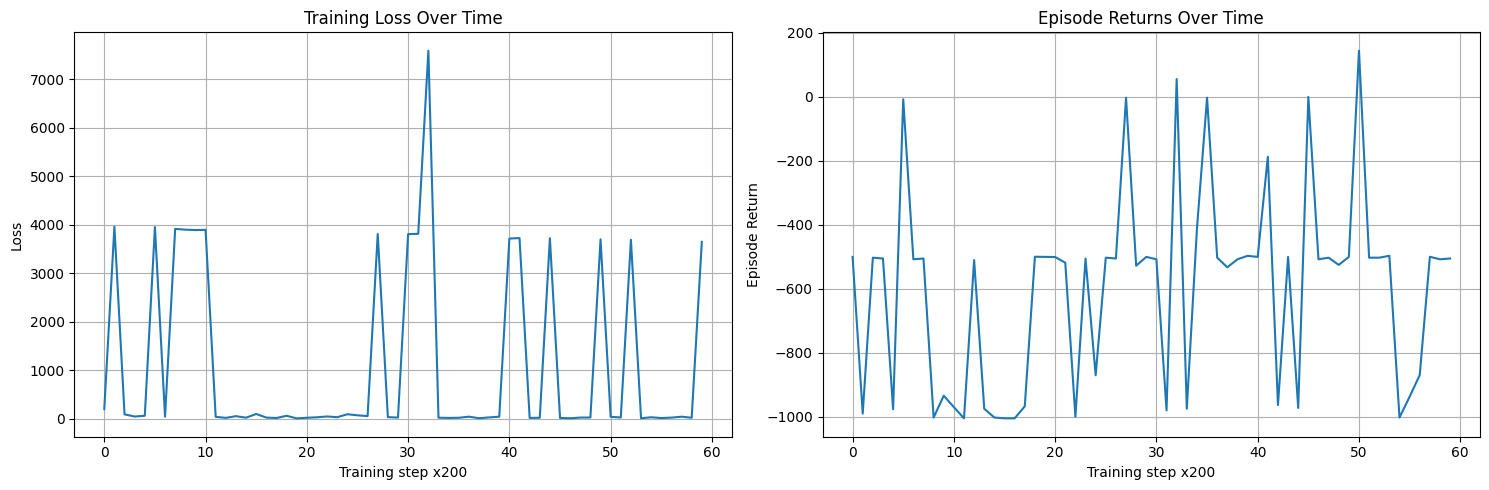

In [236]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(stage2_train_losses)
ax1.set_title('Training Loss Over Time')
ax1.set_xlabel('Training step x200')
ax1.set_ylabel('Loss')
ax1.grid(True)

ax2.plot(stage2_episode_returns)
ax2.set_title('Episode Returns Over Time')
ax2.set_xlabel('Training step x200')
ax2.set_ylabel('Episode Return')
ax2.grid(True)

plt.tight_layout()
plt.show()

Model evaluation

In [238]:
import time
stage2_total_returns = []
stage2_total_steps = []

engine_config_channel.set_configuration_parameters(time_scale=2)
for episode in range(10):
    time_step = tf_env_2.reset()
    episode_return = 0.0
    steps_in_episode = 0

    while not time_step.is_last():
        action_step = eval_policy_2.action(time_step)
        time_step = tf_env_2.step(action_step.action)
        episode_return += time_step.reward
        steps_in_episode += 1

    stage2_total_returns.append(episode_return.numpy()[0])
    stage2_total_steps.append(steps_in_episode)
    print(f"Episode {episode+1}: Return = {episode_return.numpy()[0]:.2f}, Steps = {steps_in_episode}")

avg_return = np.mean(stage2_total_returns)
avg_steps = np.mean(stage2_total_steps)
std_return = np.std(stage2_total_returns)

print(f"Average Return: {avg_return:.2f}")
print(f"Average Episode Length: {avg_steps:.1f} steps")
print(f"Best Episode: {max(stage2_total_returns):.2f}")
print(f"Worst Episode: {min(stage2_total_returns):.2f}")

Episode 1: Return = -501.50, Steps = 13
Episode 2: Return = -0.50, Steps = 407
Episode 3: Return = -0.50, Steps = 407
Episode 4: Return = -500.50, Steps = 42
Episode 5: Return = -500.50, Steps = 13
Episode 6: Return = -0.50, Steps = 407
Episode 7: Return = -0.50, Steps = 407
Episode 8: Return = -0.50, Steps = 407
Episode 9: Return = -486.80, Steps = 34
Episode 10: Return = 680.38, Steps = 407
Average Return: -131.14
Average Episode Length: 254.4 steps
Best Episode: 680.38
Worst Episode: -501.50


In [46]:
env.close()

#### **Proximal Policy Optimization (PPO)**
We are going to use PPO instead of a simple DQN agent, the rewards will be like this:
- Falling: -5
- Doing nothing: -0.02 (encouraging movement)
- Collecting green sphere: +2
- Collecting red sphere: -2

Creating a new environment wrapper

In [149]:
env.close()

In [27]:
env_wrapper_ppo = EnvironmentWrapper(env, behavior_name, get_state)
tf_env_ppo = tf_py_environment.TFPyEnvironment(env_wrapper_ppo)

Creating actor and critic networks

In [28]:
actor_net = actor_distribution_network.ActorDistributionNetwork(
    tf_env_ppo.observation_spec(),
    tf_env_ppo.action_spec(),
    fc_layer_params=(512, 256, 128, 64)
)

value_net = value_network.ValueNetwork(
    tf_env_ppo.observation_spec(),
    fc_layer_params=(512, 256, 128, 64)
)

Creating the agent

In [35]:
train_step_counter_ppo = tf.Variable(0)

optimizer_ppo = tf.keras.optimizers.Adam(learning_rate=0.0003)

ppo = ppo_agent.PPOAgent(
    tf_env_ppo.time_step_spec(),
    tf_env_ppo.action_spec(),
    actor_net=actor_net,
    value_net=value_net,
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    normalize_observations=False,
    normalize_rewards=False,
    use_gae=True,
    lambda_value=0.95,
    entropy_regularization=0.01,
    importance_ratio_clipping=0.2,
    discount_factor=0.99,
    value_pred_loss_coef=0.5,
    num_epochs=4,
    train_step_counter=train_step_counter_ppo,
)

ppo.initialize()

Creating the replay buffer

In [36]:
replay_buffer_ppo = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=ppo.collect_data_spec,
    batch_size=tf_env_ppo.batch_size,
    max_length=20000,
)

In [37]:
def rb_observer(traj):
    replay_buffer_ppo.add_batch(traj)

driver = DynamicEpisodeDriver(
    tf_env_ppo,
    ppo.collect_policy,
    observers=[rb_observer],
    num_episodes=5,
)

In [38]:
num_iterations_ppo = 1000
eval_interval_ppo = 10
speed_ppo = 1000

In [ ]:
ppo_train_losses = []
ppo_episode_returns = []

engine_config_channel.set_configuration_parameters(time_scale=speed_ppo)

for iteration in range(num_iterations_ppo):
    replay_buffer_ppo.clear()
    driver.run()

    experience = replay_buffer_ppo.gather_all()
    loss_info = ppo.train(experience)
    replay_buffer_ppo.clear()

    if iteration % eval_interval_ppo == 0:
        ts = tf_env_ppo.reset()
        eval_return = 0.0
        while not ts.is_last():
            action_step = ppo.policy.action(ts)
            ts = tf_env_ppo.step(action_step.action)
            eval_return += ts.reward
        print(f"Iter {iteration} | Eval return: {eval_return.numpy()[0]:.2f}")


print('Training complete!')

Evaluation return: 0.00 in 400 steps
Evaluation return: -5.00 in 6 steps
Evaluation return: -5.00 in 25 steps
Evaluation return: -5.00 in 17 steps
Evaluation return: -5.00 in 10 steps
Evaluation return: -5.00 in 46 steps
Evaluation return: -5.00 in 32 steps
Evaluation return: -5.00 in 41 steps
Evaluation return: -5.00 in 13 steps
Evaluation return: -5.00 in 18 steps
Evaluation return: -3.00 in 60 steps
Evaluation return: -5.00 in 11 steps
Evaluation return: -5.00 in 11 steps
Evaluation return: -5.00 in 43 steps
Evaluation return: -5.00 in 24 steps
Evaluation return: -5.00 in 10 steps
Evaluation return: -5.00 in 29 steps
Evaluation return: -5.00 in 23 steps
Evaluation return: -5.00 in 40 steps
Evaluation return: -5.00 in 34 steps
Evaluation return: -5.00 in 12 steps
Evaluation return: -5.00 in 20 steps
Evaluation return: -5.00 in 39 steps
Evaluation return: -5.00 in 21 steps
Evaluation return: -5.00 in 36 steps
Evaluation return: -5.00 in 19 steps
Evaluation return: -5.00 in 36 steps
Ev

KeyboardInterrupt: 

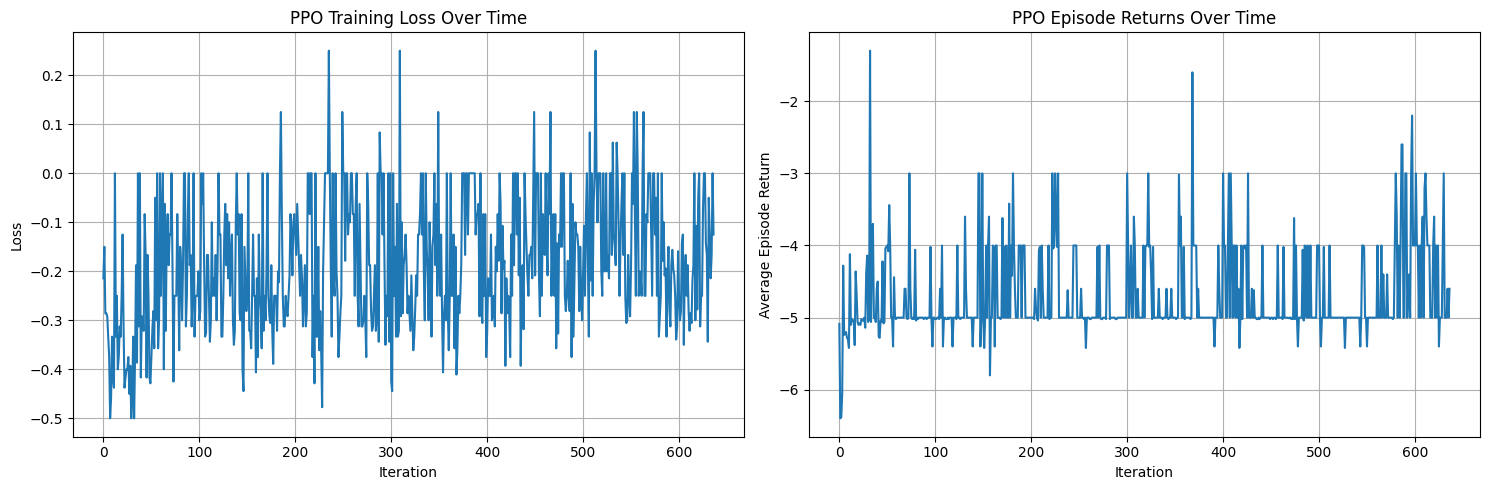

In [21]:
# Visualize PPO training results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(ppo_train_losses)
ax1.set_title('PPO Training Loss Over Time')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax1.grid(True)

ax2.plot(ppo_episode_returns)
ax2.set_title('PPO Episode Returns Over Time')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Average Episode Return')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [22]:
# Evaluate PPO agent
ppo_total_returns = []
ppo_total_steps = []

engine_config_channel.set_configuration_parameters(time_scale=2)
for episode in range(10):
    time_step = tf_env_ppo.reset()
    episode_return = 0.0
    steps_in_episode = 0

    while not time_step.is_last():
        action_step = eval_policy_ppo.action(time_step)
        time_step = tf_env_ppo.step(action_step.action)
        episode_return += time_step.reward
        steps_in_episode += 1

    ppo_total_returns.append(episode_return.numpy()[0])
    ppo_total_steps.append(steps_in_episode)
    print(f"Episode {episode+1}: Return = {episode_return.numpy()[0]:.2f}, Steps = {steps_in_episode}")

avg_return = np.mean(ppo_total_returns)
avg_steps = np.mean(ppo_total_steps)
std_return = np.std(ppo_total_returns)

print(f"Average Return: {avg_return:.2f}")
print(f"Average Episode Length: {avg_steps:.1f} steps")
print(f"Best Episode: {max(ppo_total_returns):.2f}")
print(f"Worst Episode: {min(ppo_total_returns):.2f}")

Episode 1: Return = -5.00, Steps = 32
Episode 2: Return = -5.00, Steps = 40
Episode 3: Return = -5.00, Steps = 35
Episode 4: Return = -5.00, Steps = 22
Episode 5: Return = -5.00, Steps = 13
Episode 6: Return = -3.00, Steps = 67
Episode 7: Return = -5.00, Steps = 6
Episode 8: Return = -5.00, Steps = 15
Episode 9: Return = -5.00, Steps = 37
Episode 10: Return = -5.00, Steps = 23
Average Return: -4.80
Average Episode Length: 29.0 steps
Best Episode: -3.00
Worst Episode: -5.00
